<a href="https://colab.research.google.com/github/myazann/Lung_Cancer/blob/main/Lung_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' > /dev/null

!rm -rf sample_data
!rm sample.py
!rm README.md

!cp ./drive/MyDrive/bboxs.json .
!cp ./drive/MyDrive/lung_ct_train.zip .
!cp ./drive/MyDrive/lung_ct_val.zip .

!unzip lung_ct_train.zip > /dev/null
!rm lung_ct_train.zip
!unzip lung_ct_val.zip > /dev/null
!rm lung_ct_val.zip

     |████████████████████████████████| 276kB 15.0MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=7bd8933e4b156cd5e330e870da01d22ba3a91fbe5ab67a7d6b03a4ff7ecd7bed
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-psnu1qlr
rm: cannot remove 'sample.py': No such file or directory
rm: cannot remove 'README.md': No such file or directory


In [2]:
import pandas as pd
import json
import os
import copy
import random
import numpy as np
import torchvision.transforms as transforms
import torch
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import itertools
import torchvision

from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader, build_detection_test_loader, DatasetFromList
import detectron2.data.transforms as T
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

## Create data according to Detectron dataset format


In [3]:
category_map = {
                "A": 0,
                "B": 1,
                "E": 2,
                "G": 3,
                0: "A",
                1: "B",
                2: "E",
                3: "G"
                  }

def get_ct_scans(mode):

  with open('bboxs.json') as json_file:
    bboxs = json.load(json_file)

  dataset_dicts = []
  path = "lung_ct_" + mode

  for ptnt in os.listdir(path):
    for i, img in enumerate(os.listdir(path + "/" + ptnt)):

      label = {}
      bboxes = bboxs[img.split(".j")[0]]

      label["file_name"] = path + "/" + ptnt + "/" + img
      label["image_id"] = i
      label["height"] = 512
      label["width"] = 512
      annot = []
      boxes = {
      "bbox": [int(bboxes["xmin"]), int(bboxes["ymin"]), int(bboxes["xmax"]), int(bboxes["ymax"])],
      "bbox_mode": BoxMode.XYXY_ABS,
      "category_id": category_map[bboxes["class"]],
      }
      annot.append(boxes)
      label["annotations"] = annot

      dataset_dicts.append(label)  

  return dataset_dicts

for d in ["train", "val"]:
  DatasetCatalog.register("ct_" + d, lambda d=d: get_ct_scans(d))
  MetadataCatalog.get("ct_" + d).set(thing_classes=["A", "B", "E", "G"], evaluator_type="coco")

ct_train = DatasetCatalog.get("ct_train")
ct_val = DatasetCatalog.get("ct_val")

ct_metadata = MetadataCatalog.get("ct_train")

In [4]:
class CTDataset(torch.utils.data.Dataset):

    def __init__(self, mode):
      self.mode = mode
      if mode == "train":
        self.data = ct_train
      else:
        self.data = ct_val

    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):

      item_data = dict((key, value) for key, value in self.data[index].items() if key != "annotations")
      item_data["image"] = torch.tensor(cv2.imread(item_data["file_name"])).view(3, 512, 512)

      if self.mode == "train":
        item_data["image"] = self.transformations()(item_data["image"])

      item_label = self.data[index]["annotations"]

      return item_data, item_label

    def transformations(self):
      
      return transforms.Compose([
          transforms.ColorJitter(0.35, 0.5, 0.5),
          transforms.RandomAffine(degrees = 0, shear=[5, 7]),
          transforms.RandomErasing(0.5, scale=(0.005, 0.1), value=255),
          ]
      )

## Class Distributions

In [ ]:
pd.Series([category_map[k["annotations"][0]["category_id"]] for k in ct_train]).value_counts()

A    4133
G    1269
B     422
E      14
dtype: int64

In [ ]:
pd.Series([category_map[k["annotations"][0]["category_id"]] for k in ct_val]).value_counts()

A    1195
B     314
G     273
dtype: int64

## Created a customer trainer to enable evaluation 

In [5]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):

        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")

        evaluator_list = []
        evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type

        if evaluator_type in ["coco", "coco_panoptic_seg"]:
            evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))

        elif evaluator_type == "pascal_voc":
            return PascalVOCDetectionEvaluator(dataset_name)

        if len(evaluator_list) == 0:
            raise NotImplementedError(
                "no Evaluator for the dataset {} with the type {}".format(
                    dataset_name, evaluator_type
                )
            )
        elif len(evaluator_list) == 1:
            return evaluator_list[0]
        return DatasetEvaluators(evaluator_list)

    def build_detection_test_loader():
      return DataLoader(CTDataset("val"))

    def build_detection_train_loader():
      return DataLoader(CTDataset("train"), batch_size=32)
    

## Training

In [6]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("ct_train",)
cfg.DATASETS.TEST = ("ct_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml") 

cfg.SOLVER.BASE_LR = 0.0005  
cfg.SOLVER.MAX_ITER = 3000    
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   ##512 leads to overfitting, 128 underfits.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False) ## False if its the first time.
trainer.train()

[05/04 18:10:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:08, 18.9MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[05/04 18:10:58 d2.engine.train_loop]: Starting training from iteration 0
[05/04 18:11:47 d2.utils.events]:  eta: 2:00:38  iter: 19  total_loss: 1.993  loss_cls: 1.823  loss_box_reg: 0.04982  loss_rpn_cls: 0.1223  loss_rpn_loc: 0.01012  time: 2.4296  data_time: 0.2214  lr: 9.9905e-06  max_mem: 11126M
[05/04 18:12:36 d2.utils.events]:  eta: 2:00:36  iter: 39  total_loss: 1.582  loss_cls: 1.404  loss_box_reg: 0.06811  loss_rpn_cls: 0.1185  loss_rpn_loc: 0.01007  time: 2.4443  data_time: 0.2104  lr: 1.998e-05  max_mem: 11126M
[05/04 18:13:26 d2.utils.events]:  eta: 2:01:03  iter: 59  total_loss: 0.9558  loss_cls: 0.7371  loss_box_reg: 0.06222  loss_rpn_cls: 0.1134  loss_rpn_loc: 0.01006  time: 2.4615  data_time: 0.2137  lr: 2.997e-05  max_mem: 11126M
[05/04 18:14:16 d2.utils.events]:  eta: 2:00:57  iter: 79  total_loss: 0.5084  loss_cls: 0.2996  loss_box_reg: 0.06993  loss_rpn_cls: 0.1118  loss_rpn_loc: 0.009895  time: 2.4718  data_time: 0.2101  lr: 3.9961e-05  max_mem: 11126M
[05/04 18:1

## Let's visualize some of the predictions

In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.25   
predictor = DefaultPredictor(cfg)

In [8]:
##Function to visualize an image with its corresponding label

def get_img_with_bbox(im, labels, outputs):

  d_im = copy.deepcopy(im.squeeze())
  gt_bbox = labels["bbox"]
  gt_class = category_map[labels["category_id"]]

  v = Visualizer(d_im[:, :, ::-1],
                metadata=ct_metadata, 
                scale=1,
                instance_mode = 1)

  if len(outputs.get_fields()["pred_boxes"]) != 0:

    out = outputs[0].get_fields()["pred_boxes"][0].tensor[0]
    label = category_map[outputs[0].get_fields()["pred_classes"][0].item()]
    score = "{:.0%}".format(outputs[0].get_fields()["scores"][0].item())
    text = "Pred:" + label + " " + score

    xmin = out[0]
    ymin = out[1]
    xmax = out[2]
    ymax = out[3]

    cv2.rectangle(d_im, (xmin, ymin), (xmax, ymax), (255, 255, 255), 2)
    cv2.putText(d_im, text, (xmin-50,ymin-10), cv2.FONT_HERSHEY_DUPLEX, fontScale=0.5, color=(255, 255, 255), thickness=1)

  ##out = v.draw_instance_predictions(outputs.to("cpu"))
  ##d_im = out.get_image()

  xmin = gt_bbox[0]
  ymin = gt_bbox[1]
  xmax = gt_bbox[2]
  ymax = gt_bbox[3]

  cv2.rectangle(d_im, (xmin, ymin), (xmax, ymax), (255, 200, 200), 2)
  cv2.putText(d_im, "Real:" + gt_class, (xmax,ymax+10), cv2.FONT_HERSHEY_DUPLEX, fontScale=0.5, color=(255, 200, 200), thickness=1)

  display(Image.fromarray(d_im))

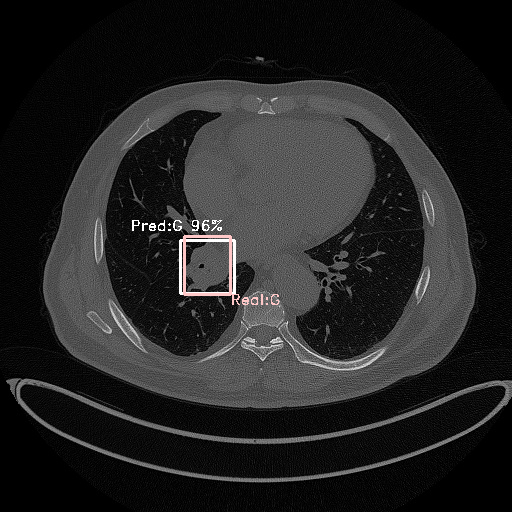

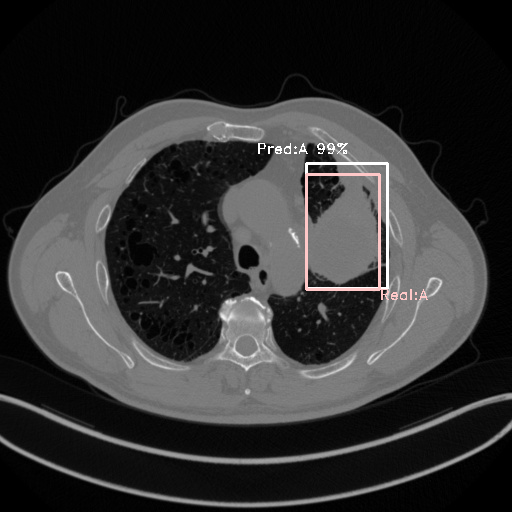

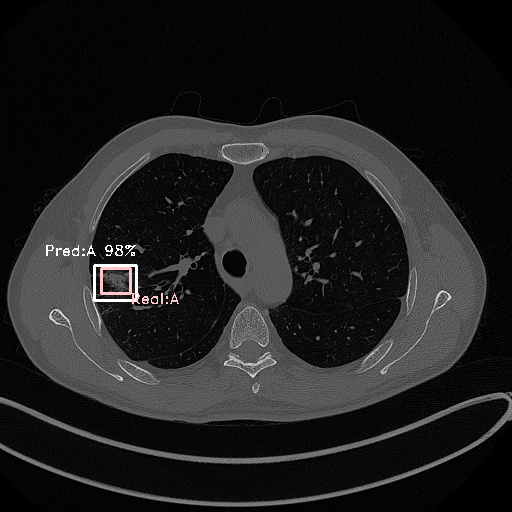

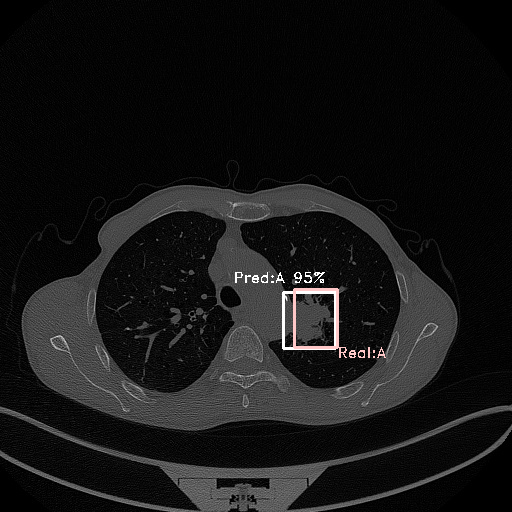

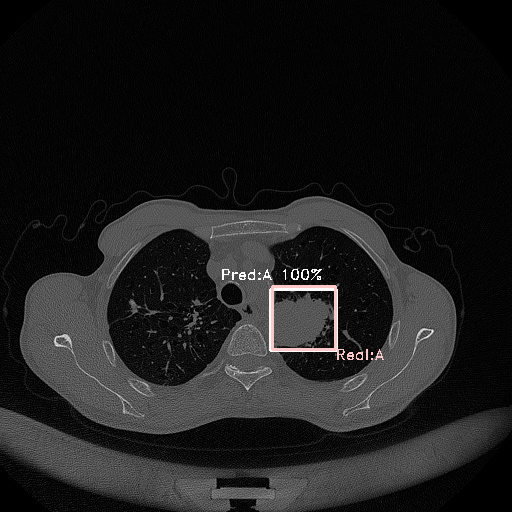

In [9]:
rs = random.sample(range(0, len(ct_val)), 5)

for elem in rs:
  img = cv2.imread(ct_val[elem]["file_name"])
  outputs = predictor(img)["instances"]
  
  get_img_with_bbox(img, ct_val[elem]["annotations"][0], outputs)
  print("\n")